# July 17 Progress Meeting

## Objective

The objective of this meeting is to go over the following:

1. LSTM results (sent previously in an email)
2. LSTM results adding population statistics
3. Population code: Discuss the following ideas
    - Copy the population value for that year into each month in the main dataset
    - Linearly interpolate the population to see how the results differ (haven't done yet)
4. Show transformer code and some results
5. Discuss path forward with transformer code
6. Discuss 290 or similar class
7. Discuss objectives for next meeting and set a date

## Code Demo

Below is a demo of the code, slightly modified to make for better use during presentation

In [40]:
import pandas as pd 
import torch.nn as nn 
import torch.optim as optim 
from models import LSTM, TransformerModel
from trainer import Trainer 
from data_utils import prep_data
from loss_functions import RMSELoss
from data_loader import combine_vf_fire_pop_data, combine_vf_wildfire_data
from transformer_modules.attention import MultiHeadAttention

def main(model_flag:str, county_name:str, bAdd_Pop:bool, epochs: int = 300, show_plot:bool = True ):

  fire_data_path       = "../data/CAL_FIRE_Wildland_PublicReport_2000to2018.csv"
  vf_data_path         = "../data/coccidioidomycosis_m2000_2015_v0.1.csv"
  pop1_data_path       = "../data/cali_county_pop_2000_2010.csv" 
  pop2_data_path       = "../data/cali_county_pop_2010_2020.csv"
  start_year           = "2006"
  end_year             = "2015"
  # county_name          = "Tulare"
  if bAdd_Pop:
    source_column_labels = ['Fire Incident Count', 'VF Case Count', 'Population']
  else:
    source_column_labels = ['Fire Incident Count', 'VF Case Count']
  
  split_frac           = .85
  lookback             = 6
  # input_size           = 3
  hidden_size          = 64
  num_layers           = 2
  dropout              = 0.2
  learning_rate        = 0.001
  # epochs               = 300
  weight_decay         = 1e-5
  if bAdd_Pop:
    title_text         = "(Population Added)"
  else:
    title_text         = "(Excl. Population)"
  # model_flag           = "transformer"

  # Transformer Properties
  if model_flag == "transformer":
    d_model         = 32
    nheads          = 2
    dim_feedforward = 64
    num_layers      = 1
    dropout         = 0.2

  if bAdd_Pop:
    df = combine_vf_fire_pop_data(pop1_data_path, pop2_data_path, vf_data_path, fire_data_path, county_name,
                                          start_year, end_year, bInterp=False)
    input_size = 3
  else:
    df = combine_vf_wildfire_data(fire_path=fire_data_path, vf_cases_path=vf_data_path, county_name=county_name)
    input_size = 2

  X_train, y_train, X_test, y_test, scaler = prep_data(df, source_column_labels, 
                                                        split_frac, lookback, b_scaler=True)

  # Able to be swapped out with other models (I hope)
  if model_flag == "lstm":
    model     = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
  elif model_flag == "transformer":
    model = TransformerModel(input_size= input_size, d_model = d_model, nhead= nheads, num_layers = num_layers,
                             dim_feedforward= dim_feedforward, dropout=dropout, attention_impl=MultiHeadAttention)
  else:
    raise NotImplementedError("Other Architectures besides LSTM and Transformer not implemented. " \
                              "If this is a mistake, check your spelling in model_flag variable.")
  criterion = RMSELoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)  

  trainer = Trainer(model = model, criterion = criterion, optimizer = optimizer, scaler = scaler)
  trainer.train(X_train, y_train, X_test, y_test, epochs)

  y_pred, y_true = trainer.evaluate(X_test, y_test)
  if show_plot:
    trainer.visualize_results(y_true, y_pred, county_name, model_type = model_flag, 
                            title_text = title_text, show_plot=True, save_fig = False)
  return y_pred, y_true

### LSTM Tests

#### Without Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2557, Testing Loss 0.0876
Epoch 11/300 - Training Loss 0.2051, Testing Loss 0.2362
Epoch 21/300 - Training Loss 0.1955, Testing Loss 0.1633
Epoch 31/300 - Training Loss 0.1889, Testing Loss 0.1782
Epoch 41/300 - Training Loss 0.1769, Testing Loss 0.1451
Epoch 51/300 - Training Loss 0.1631, Testing Loss 0.0983
Epoch 61/300 - Training Loss 0.1564, Testing Loss 0.0742
Epoch 71/300 - Training Loss 0.1482, Testing Loss 0.0906
Epoch 81/300 - Training Loss 0.1362, Testing Loss 0.0811
Epoch 91/300 - Training Loss 0.1262, Testing Loss 0.0872
Epoch 101/300 - Training Loss 0.1206, Testing Loss 0.0834
Epoch 111/300 - Training Loss 0.1129, Testing Loss 0.0909
Epoch 121/300 - Training Loss 0.1116, Testing Loss 0.0830
Epoch 131/300 - Training Loss 0.1119, Testing Loss 0.0799
Epoch 141/300 - Training Loss 0.1074, Testing Loss 0.0729
Epoch 151/300 - Training Loss 0.1043, Testing Loss 0.0793
Epoch 161/300 - Training Loss 0.0991, Testing Loss 0.0782
Epoch 171/300 - Training 

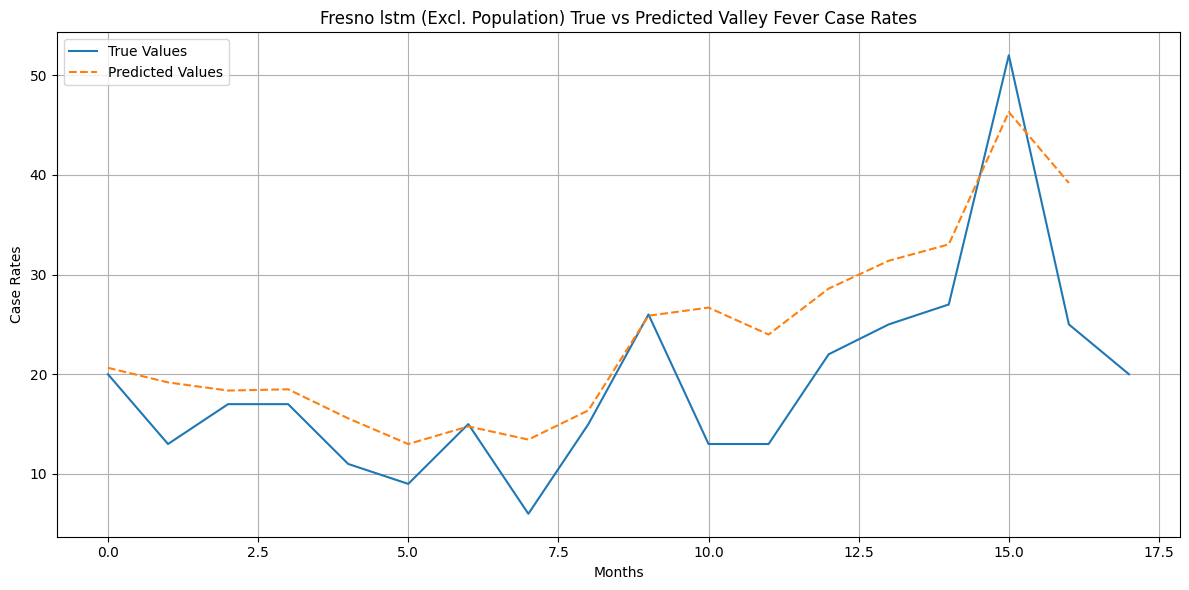

(array([16.72846209, 20.64505385, 19.18081588, 18.36323693, 18.48965359,
        15.57309204, 12.99600231, 14.76678416, 13.44504193, 16.37852841,
        25.87255803, 26.68657668, 23.98182669, 28.59263241, 31.38471186,
        33.02666777, 46.29756421, 39.18773961]),
 array([20.00000039, 13.0000002 , 16.99999959, 16.99999959, 10.99999981,
         8.99999989, 14.99999966,  6.        , 14.99999966, 25.99999925,
        13.0000002 , 13.0000002 , 21.9999994 , 25.00000021, 27.00000013,
        52.00000012, 25.00000021, 20.00000039]))

In [25]:
main(model_flag="lstm", county_name="Fresno", bAdd_Pop=False, epochs = 300)

#### With Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3474, Testing Loss 0.1176
Epoch 11/300 - Training Loss 0.1999, Testing Loss 0.2349
Epoch 21/300 - Training Loss 0.1966, Testing Loss 0.1739
Epoch 31/300 - Training Loss 0.1917, Testing Loss 0.1574
Epoch 41/300 - Training Loss 0.1850, Testing Loss 0.1724
Epoch 51/300 - Training Loss 0.1738, Testing Loss 0.1244
Epoch 61/300 - Training Loss 0.1613, Testing Loss 0.0731
Epoch 71/300 - Training Loss 0.1553, Testing Loss 0.0621
Epoch 81/300 - Training Loss 0.1509, Testing Loss 0.0720
Epoch 91/300 - Training Loss 0.1391, Testing Loss 0.0668
Epoch 101/300 - Training Loss 0.1290, Testing Loss 0.0754
Epoch 111/300 - Training Loss 0.1246, Testing Loss 0.0843
Epoch 121/300 - Training Loss 0.1141, Testing Loss 0.0752
Epoch 131/300 - Training Loss 0.1103, Testing Loss 0.0822
Epoch 141/300 - Training Loss 0.1021, Testing Loss 0.0770
Epoch 151/300 - Training Loss 0.1074, Testing Loss 0.0803
Epoch 161/300 - Training Loss 0.1029, Testing Loss 0.0796
Epoch 171/300 - Training 

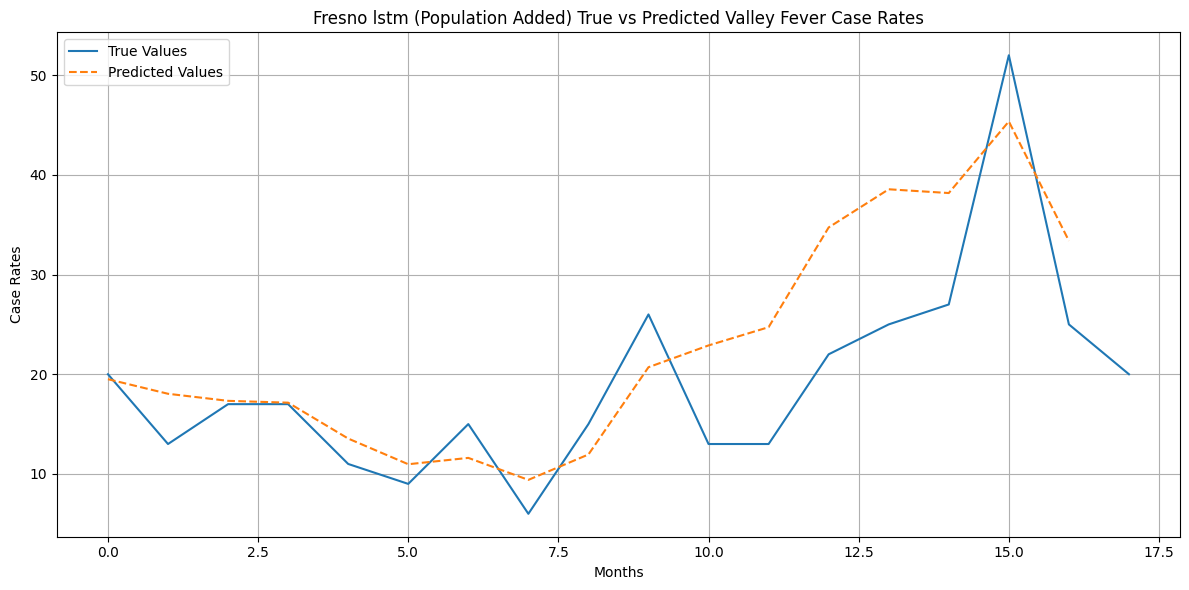

In [18]:
main(model_flag="lstm", county_name="Fresno", bAdd_Pop=True)

### Tranformer Model Tests (MultiHeadAttention)

#### Without Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4404, Testing Loss 0.0931
Epoch 11/300 - Training Loss 0.3588, Testing Loss 0.1409
Epoch 21/300 - Training Loss 0.2800, Testing Loss 0.2430
Epoch 31/300 - Training Loss 0.2483, Testing Loss 0.1461
Epoch 41/300 - Training Loss 0.2073, Testing Loss 0.1397
Epoch 51/300 - Training Loss 0.2067, Testing Loss 0.1469
Epoch 61/300 - Training Loss 0.2093, Testing Loss 0.1302
Epoch 71/300 - Training Loss 0.1749, Testing Loss 0.1309
Epoch 81/300 - Training Loss 0.1760, Testing Loss 0.1099
Epoch 91/300 - Training Loss 0.1669, Testing Loss 0.1026
Epoch 101/300 - Training Loss 0.1517, Testing Loss 0.0895
Epoch 111/300 - Training Loss 0.1685, Testing Loss 0.0844
Epoch 121/300 - Training Loss 0.1600, Testing Loss 0.0938
Epoch 131/300 - Training Loss 0.1408, Testing Loss 0.0735
Epoch 141/300 - Training Loss 0.1364, Testing Loss 0.0703
Epoch 151/300 - Training Loss 0.1422, Testing Loss 0.0771
Epoch 161/300 - Training Loss 0.1457, Testing Loss 0.0859
Epoch 171/300 - Training 

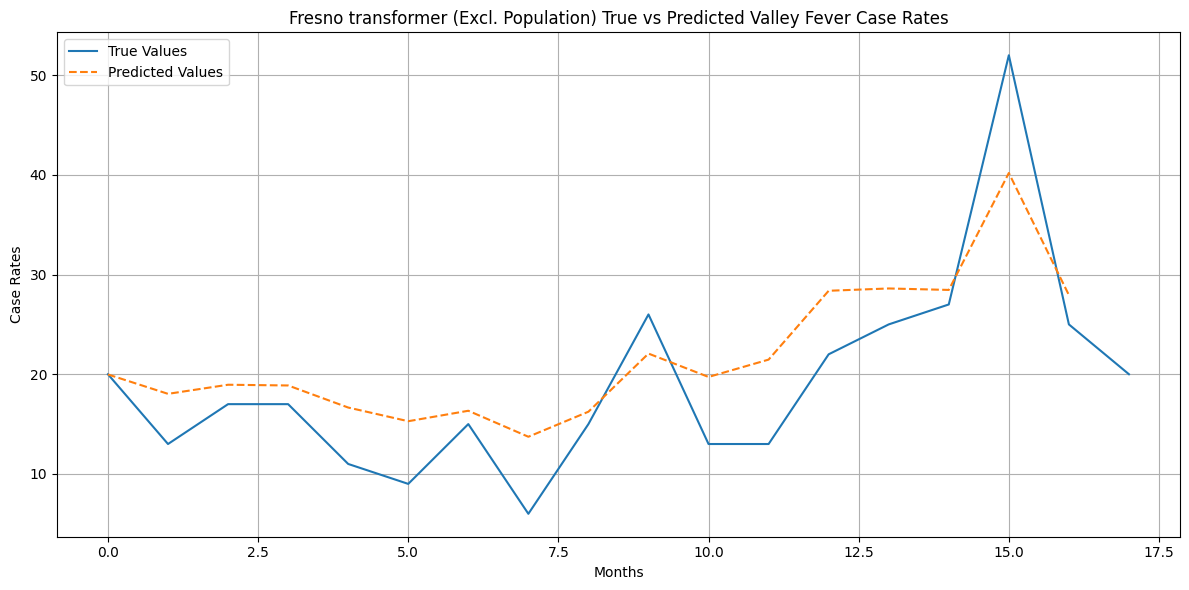

In [19]:
main(model_flag="transformer", county_name="Fresno", bAdd_Pop=False)

#### With Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4727, Testing Loss 0.0785
Epoch 11/300 - Training Loss 0.2824, Testing Loss 0.1132
Epoch 21/300 - Training Loss 0.2781, Testing Loss 0.2092
Epoch 31/300 - Training Loss 0.2241, Testing Loss 0.0821
Epoch 41/300 - Training Loss 0.1979, Testing Loss 0.1117
Epoch 51/300 - Training Loss 0.1915, Testing Loss 0.1230
Epoch 61/300 - Training Loss 0.1855, Testing Loss 0.0936
Epoch 71/300 - Training Loss 0.1667, Testing Loss 0.0908
Epoch 81/300 - Training Loss 0.1745, Testing Loss 0.0781
Epoch 91/300 - Training Loss 0.1565, Testing Loss 0.0775
Epoch 101/300 - Training Loss 0.1568, Testing Loss 0.0789
Epoch 111/300 - Training Loss 0.1560, Testing Loss 0.0765
Epoch 121/300 - Training Loss 0.1554, Testing Loss 0.0807
Epoch 131/300 - Training Loss 0.1618, Testing Loss 0.0757
Epoch 141/300 - Training Loss 0.1331, Testing Loss 0.0703
Epoch 151/300 - Training Loss 0.1343, Testing Loss 0.0722
Epoch 161/300 - Training Loss 0.1593, Testing Loss 0.0758
Epoch 171/300 - Training 

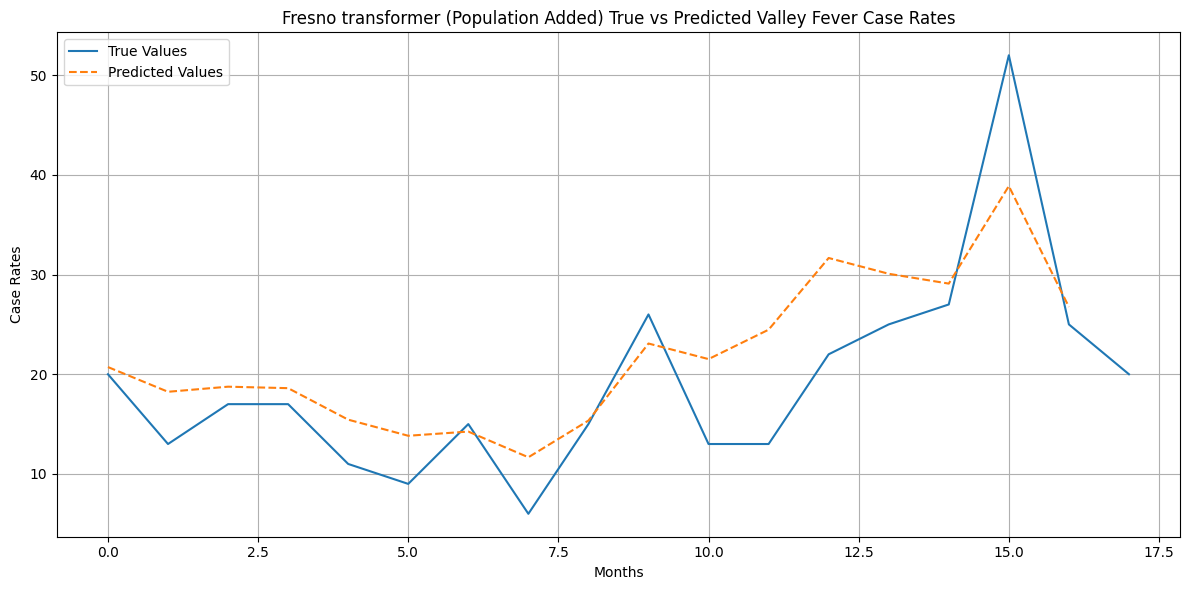

In [20]:
main(model_flag="transformer", county_name="Fresno", bAdd_Pop=True)

### Combination of Figures From Each Run

In [36]:
import matplotlib.pyplot as plt 

def model_comparison_subplots_by_county(county_name):
    model_flag_arr = ["lstm", "lstm", "transformer", "transformer"]
    bAdd_Pop_arr   = [False, True, False, True]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

    for i in range(4):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        # Get results from main
        y_pred, y_true = main(model_flag_arr[i], county_name, bAdd_Pop_arr[i], show_plot = False)

        # Plot
        ax.plot(y_true, label='True', linestyle='-')
        ax.plot(y_pred, label='Predicted', linestyle='--')
        ax.set_title(f"{model_flag_arr[i].upper()} | Pop: {bAdd_Pop_arr[i]}")
        ax.set_xlabel("Months")
        ax.set_ylabel("Valley Fever Case Count")
        ax.legend()

    plt.suptitle(f"Valley Fever Forecast for {county_name}", fontsize = 16)
    plt.tight_layout()
    plt.show()

#### Fresno County

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3054, Testing Loss 0.0879
Epoch 11/300 - Training Loss 0.1995, Testing Loss 0.2279
Epoch 21/300 - Training Loss 0.1958, Testing Loss 0.1705
Epoch 31/300 - Training Loss 0.1926, Testing Loss 0.1631
Epoch 41/300 - Training Loss 0.1831, Testing Loss 0.1716
Epoch 51/300 - Training Loss 0.1718, Testing Loss 0.1355
Epoch 61/300 - Training Loss 0.1589, Testing Loss 0.0867
Epoch 71/300 - Training Loss 0.1481, Testing Loss 0.0813
Epoch 81/300 - Training Loss 0.1416, Testing Loss 0.0879
Epoch 91/300 - Training Loss 0.1380, Testing Loss 0.0816
Epoch 101/300 - Training Loss 0.1269, Testing Loss 0.0931
Epoch 111/300 - Training Loss 0.1132, Testing Loss 0.1002
Epoch 121/300 - Training Loss 0.1158, Testing Loss 0.0789
Epoch 131/300 - Training Loss 0.1135, Testing Loss 0.0885
Epoch 141/300 - Training Loss 0.1147, Testing Loss 0.0793
Epoch 151/300 - Training Loss 0.1136, Testing Loss 0.0833
Epoch 161/300 - Training Loss 0.1046, Testing Loss 0.0750
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2755, Testing Loss 0.0801
Epoch 11/300 - Training Loss 0.2085, Testing Loss 0.2540
Epoch 21/300 - Training Loss 0.1964, Testing Loss 0.1545
Epoch 31/300 - Training Loss 0.1900, Testing Loss 0.1754
Epoch 41/300 - Training Loss 0.1797, Testing Loss 0.1334
Epoch 51/300 - Training Loss 0.1698, Testing Loss 0.0923
Epoch 61/300 - Training Loss 0.1611, Testing Loss 0.0618
Epoch 71/300 - Training Loss 0.1473, Testing Loss 0.0692
Epoch 81/300 - Training Loss 0.1375, Testing Loss 0.0742
Epoch 91/300 - Training Loss 0.1289, Testing Loss 0.0693
Epoch 101/300 - Training Loss 0.1265, Testing Loss 0.0755
Epoch 111/300 - Training Loss 0.1132, Testing Loss 0.0780
Epoch 121/300 - Training Loss 0.1145, Testing Loss 0.0739
Epoch 131/300 - Training Loss 0.1135, Testing Loss 0.0745
Epoch 141/300 - Training Loss 0.1096, Testing Loss 0.0739
Epoch 151/300 - Training Loss 0.1093, Testing Loss 0.0721
Epoch 161/300 - Training Loss 0.1069, Testing Loss 0.0786
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.8286, Testing Loss 0.4430
Epoch 11/300 - Training Loss 0.4433, Testing Loss 0.4431
Epoch 21/300 - Training Loss 0.3393, Testing Loss 0.1110
Epoch 31/300 - Training Loss 0.2603, Testing Loss 0.2628
Epoch 41/300 - Training Loss 0.2543, Testing Loss 0.1474
Epoch 51/300 - Training Loss 0.2164, Testing Loss 0.1803
Epoch 61/300 - Training Loss 0.2078, Testing Loss 0.1550
Epoch 71/300 - Training Loss 0.1886, Testing Loss 0.1434
Epoch 81/300 - Training Loss 0.2078, Testing Loss 0.1429
Epoch 91/300 - Training Loss 0.1909, Testing Loss 0.1280
Epoch 101/300 - Training Loss 0.1868, Testing Loss 0.1000
Epoch 111/300 - Training Loss 0.1748, Testing Loss 0.1009
Epoch 121/300 - Training Loss 0.1701, Testing Loss 0.0903
Epoch 131/300 - Training Loss 0.1486, Testing Loss 0.0813
Epoch 141/300 - Training Loss 0.1720, Testing Loss 0.0954
Epoch 151/300 - Training Loss 0.1562, Testing Loss 0.0754
Epoch 161/300 - Training Loss 0.1597, Testing Loss 0.0847
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.7309, Testing Loss 0.5944
Epoch 11/300 - Training Loss 0.3537, Testing Loss 0.1555
Epoch 21/300 - Training Loss 0.3047, Testing Loss 0.1476
Epoch 31/300 - Training Loss 0.2399, Testing Loss 0.2193
Epoch 41/300 - Training Loss 0.2555, Testing Loss 0.1636
Epoch 51/300 - Training Loss 0.2156, Testing Loss 0.1599
Epoch 61/300 - Training Loss 0.2291, Testing Loss 0.1591
Epoch 71/300 - Training Loss 0.2123, Testing Loss 0.1616
Epoch 81/300 - Training Loss 0.2160, Testing Loss 0.1307
Epoch 91/300 - Training Loss 0.1924, Testing Loss 0.1056
Epoch 101/300 - Training Loss 0.1805, Testing Loss 0.0928
Epoch 111/300 - Training Loss 0.1506, Testing Loss 0.0865
Epoch 121/300 - Training Loss 0.1563, Testing Loss 0.0745
Epoch 131/300 - Training Loss 0.1809, Testing Loss 0.0844
Epoch 141/300 - Training Loss 0.1637, Testing Loss 0.0837
Epoch 151/300 - Training Loss 0.1505, Testing Loss 0.0820
Epoch 161/300 - Training Loss 0.1426, Testing Loss 0.0813
Epoch 171/300 - Training 

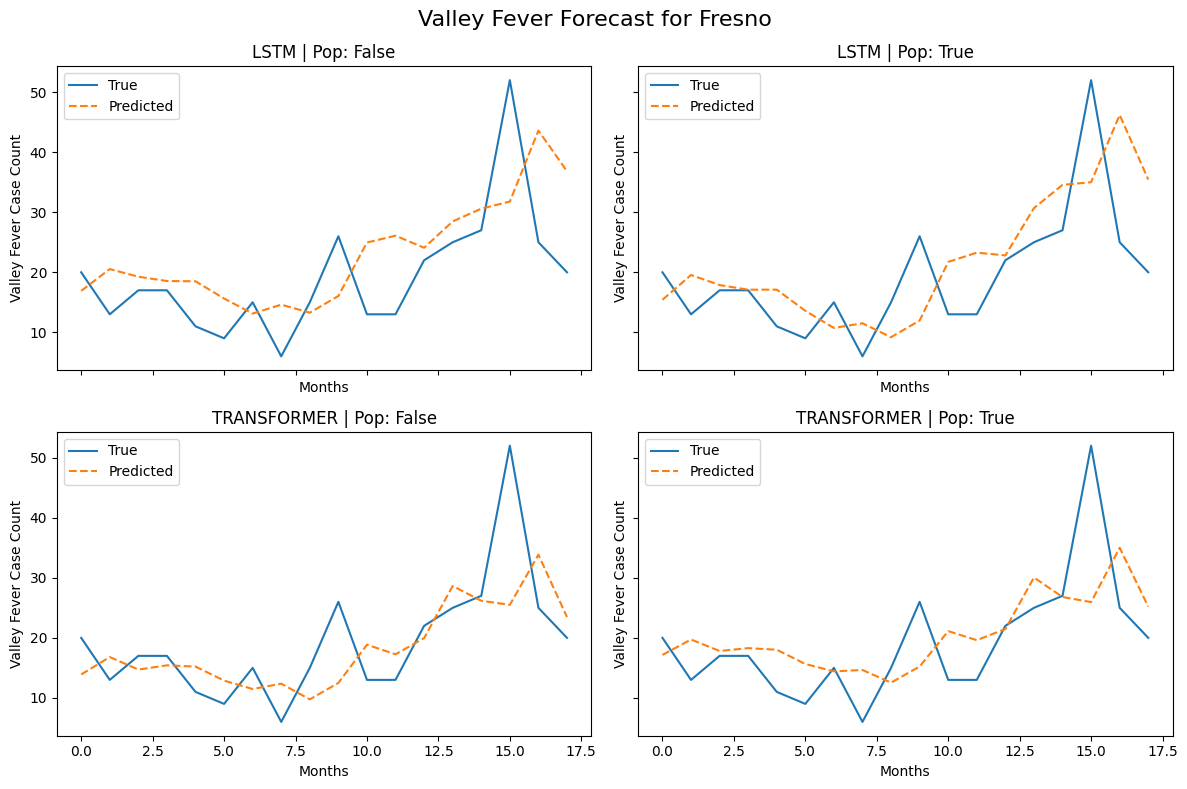

In [37]:
model_comparison_subplots_by_county("Fresno")

#### Tulare County

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4070, Testing Loss 0.2244
Epoch 11/300 - Training Loss 0.2044, Testing Loss 0.1609
Epoch 21/300 - Training Loss 0.1955, Testing Loss 0.1910
Epoch 31/300 - Training Loss 0.1958, Testing Loss 0.1516
Epoch 41/300 - Training Loss 0.1920, Testing Loss 0.1934
Epoch 51/300 - Training Loss 0.1908, Testing Loss 0.1659
Epoch 61/300 - Training Loss 0.1888, Testing Loss 0.1738
Epoch 71/300 - Training Loss 0.1865, Testing Loss 0.1678
Epoch 81/300 - Training Loss 0.1859, Testing Loss 0.1661
Epoch 91/300 - Training Loss 0.1810, Testing Loss 0.1612
Epoch 101/300 - Training Loss 0.1803, Testing Loss 0.1606
Epoch 111/300 - Training Loss 0.1753, Testing Loss 0.1588
Epoch 121/300 - Training Loss 0.1662, Testing Loss 0.1612
Epoch 131/300 - Training Loss 0.1618, Testing Loss 0.1726
Epoch 141/300 - Training Loss 0.1650, Testing Loss 0.1590
Epoch 151/300 - Training Loss 0.1594, Testing Loss 0.1567
Epoch 161/300 - Training Loss 0.1570, Testing Loss 0.1627
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2768, Testing Loss 0.1208
Epoch 11/300 - Training Loss 0.2035, Testing Loss 0.2365
Epoch 21/300 - Training Loss 0.1927, Testing Loss 0.1582
Epoch 31/300 - Training Loss 0.1880, Testing Loss 0.1609
Epoch 41/300 - Training Loss 0.1831, Testing Loss 0.1392
Epoch 51/300 - Training Loss 0.1789, Testing Loss 0.1240
Epoch 61/300 - Training Loss 0.1766, Testing Loss 0.1221
Epoch 71/300 - Training Loss 0.1728, Testing Loss 0.1237
Epoch 81/300 - Training Loss 0.1676, Testing Loss 0.1242
Epoch 91/300 - Training Loss 0.1613, Testing Loss 0.1295
Epoch 101/300 - Training Loss 0.1592, Testing Loss 0.1279
Epoch 111/300 - Training Loss 0.1545, Testing Loss 0.1282
Epoch 121/300 - Training Loss 0.1555, Testing Loss 0.1290
Epoch 131/300 - Training Loss 0.1523, Testing Loss 0.1279
Epoch 141/300 - Training Loss 0.1513, Testing Loss 0.1286
Epoch 151/300 - Training Loss 0.1475, Testing Loss 0.1297
Epoch 161/300 - Training Loss 0.1474, Testing Loss 0.1306
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4109, Testing Loss 0.3282
Epoch 11/300 - Training Loss 0.2617, Testing Loss 0.2525
Epoch 21/300 - Training Loss 0.2479, Testing Loss 0.2188
Epoch 31/300 - Training Loss 0.2358, Testing Loss 0.1746
Epoch 41/300 - Training Loss 0.2231, Testing Loss 0.1793
Epoch 51/300 - Training Loss 0.2197, Testing Loss 0.2084
Epoch 61/300 - Training Loss 0.2049, Testing Loss 0.1899
Epoch 71/300 - Training Loss 0.2009, Testing Loss 0.1840
Epoch 81/300 - Training Loss 0.1811, Testing Loss 0.1741
Epoch 91/300 - Training Loss 0.1868, Testing Loss 0.1785
Epoch 101/300 - Training Loss 0.1916, Testing Loss 0.1568
Epoch 111/300 - Training Loss 0.1941, Testing Loss 0.1671
Epoch 121/300 - Training Loss 0.1704, Testing Loss 0.1723
Epoch 131/300 - Training Loss 0.1908, Testing Loss 0.1678
Epoch 141/300 - Training Loss 0.1754, Testing Loss 0.1651
Epoch 151/300 - Training Loss 0.1933, Testing Loss 0.1652
Epoch 161/300 - Training Loss 0.1735, Testing Loss 0.1568
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2910, Testing Loss 0.1532
Epoch 11/300 - Training Loss 0.2808, Testing Loss 0.1529
Epoch 21/300 - Training Loss 0.2089, Testing Loss 0.1741
Epoch 31/300 - Training Loss 0.2177, Testing Loss 0.1380
Epoch 41/300 - Training Loss 0.2033, Testing Loss 0.1437
Epoch 51/300 - Training Loss 0.2022, Testing Loss 0.1646
Epoch 61/300 - Training Loss 0.1923, Testing Loss 0.1647
Epoch 71/300 - Training Loss 0.1960, Testing Loss 0.1497
Epoch 81/300 - Training Loss 0.1782, Testing Loss 0.1457
Epoch 91/300 - Training Loss 0.1749, Testing Loss 0.1531
Epoch 101/300 - Training Loss 0.1764, Testing Loss 0.1466
Epoch 111/300 - Training Loss 0.1834, Testing Loss 0.1459
Epoch 121/300 - Training Loss 0.1768, Testing Loss 0.1445
Epoch 131/300 - Training Loss 0.1707, Testing Loss 0.1429
Epoch 141/300 - Training Loss 0.1778, Testing Loss 0.1424
Epoch 151/300 - Training Loss 0.1689, Testing Loss 0.1472
Epoch 161/300 - Training Loss 0.1718, Testing Loss 0.1532
Epoch 171/300 - Training 

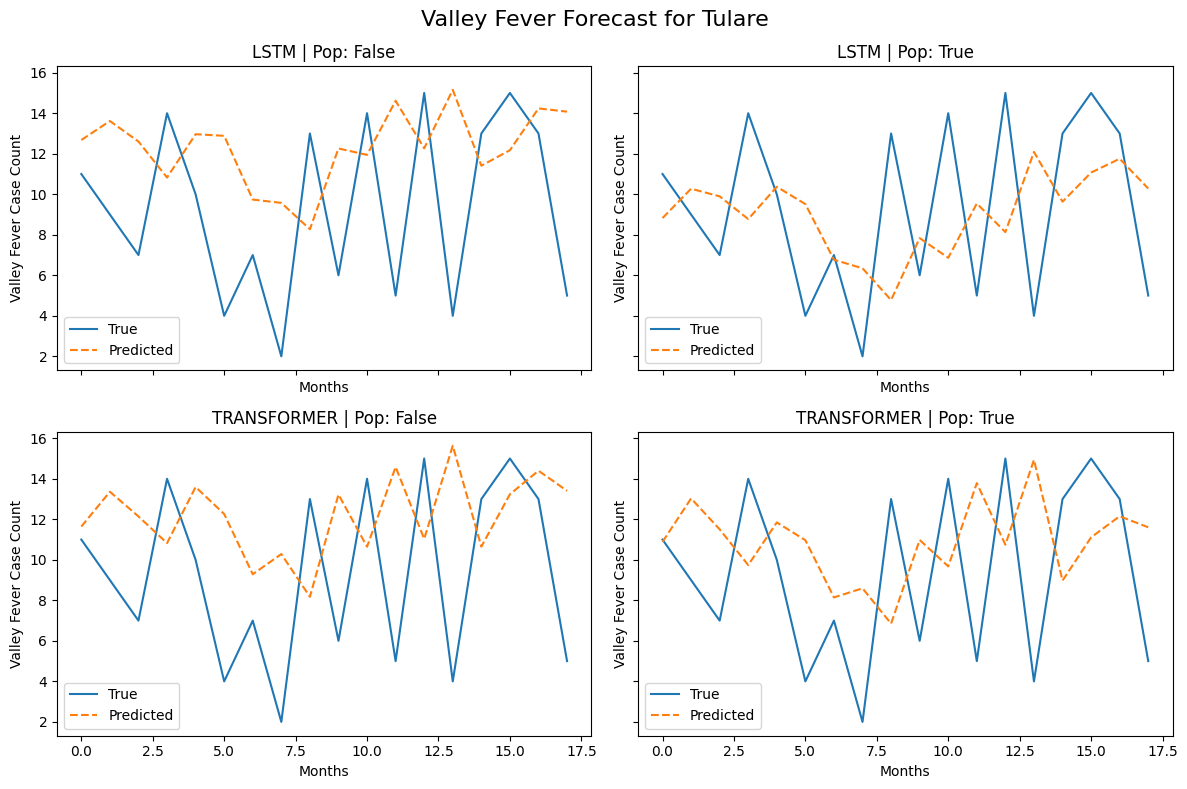

In [38]:
model_comparison_subplots_by_county("Tulare")

#### Kern County

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2452, Testing Loss 0.0952
Epoch 11/300 - Training Loss 0.1859, Testing Loss 0.1688
Epoch 21/300 - Training Loss 0.1772, Testing Loss 0.1102
Epoch 31/300 - Training Loss 0.1732, Testing Loss 0.1164
Epoch 41/300 - Training Loss 0.1666, Testing Loss 0.1159
Epoch 51/300 - Training Loss 0.1576, Testing Loss 0.0998
Epoch 61/300 - Training Loss 0.1527, Testing Loss 0.0796
Epoch 71/300 - Training Loss 0.1485, Testing Loss 0.0799
Epoch 81/300 - Training Loss 0.1420, Testing Loss 0.0786
Epoch 91/300 - Training Loss 0.1390, Testing Loss 0.0705
Epoch 101/300 - Training Loss 0.1292, Testing Loss 0.0643
Epoch 111/300 - Training Loss 0.1191, Testing Loss 0.0554
Epoch 121/300 - Training Loss 0.1117, Testing Loss 0.0478
Epoch 131/300 - Training Loss 0.1043, Testing Loss 0.0468
Epoch 141/300 - Training Loss 0.1046, Testing Loss 0.0453
Epoch 151/300 - Training Loss 0.0980, Testing Loss 0.0410
Epoch 161/300 - Training Loss 0.0946, Testing Loss 0.0406
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3345, Testing Loss 0.1781
Epoch 11/300 - Training Loss 0.1771, Testing Loss 0.1641
Epoch 21/300 - Training Loss 0.1754, Testing Loss 0.1389
Epoch 31/300 - Training Loss 0.1726, Testing Loss 0.1254
Epoch 41/300 - Training Loss 0.1684, Testing Loss 0.1698
Epoch 51/300 - Training Loss 0.1600, Testing Loss 0.1467
Epoch 61/300 - Training Loss 0.1559, Testing Loss 0.1469
Epoch 71/300 - Training Loss 0.1512, Testing Loss 0.1290
Epoch 81/300 - Training Loss 0.1471, Testing Loss 0.1110
Epoch 91/300 - Training Loss 0.1432, Testing Loss 0.0960
Epoch 101/300 - Training Loss 0.1405, Testing Loss 0.0868
Epoch 111/300 - Training Loss 0.1289, Testing Loss 0.0885
Epoch 121/300 - Training Loss 0.1248, Testing Loss 0.0779
Epoch 131/300 - Training Loss 0.1178, Testing Loss 0.0857
Epoch 141/300 - Training Loss 0.1175, Testing Loss 0.0942
Epoch 151/300 - Training Loss 0.1123, Testing Loss 0.0776
Epoch 161/300 - Training Loss 0.1094, Testing Loss 0.0642
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.7697, Testing Loss 0.4146
Epoch 11/300 - Training Loss 0.3494, Testing Loss 0.2599
Epoch 21/300 - Training Loss 0.2512, Testing Loss 0.0723
Epoch 31/300 - Training Loss 0.2413, Testing Loss 0.1626
Epoch 41/300 - Training Loss 0.2164, Testing Loss 0.1084
Epoch 51/300 - Training Loss 0.1860, Testing Loss 0.0764
Epoch 61/300 - Training Loss 0.1843, Testing Loss 0.0937
Epoch 71/300 - Training Loss 0.1584, Testing Loss 0.0861
Epoch 81/300 - Training Loss 0.1609, Testing Loss 0.0773
Epoch 91/300 - Training Loss 0.1566, Testing Loss 0.0736
Epoch 101/300 - Training Loss 0.1677, Testing Loss 0.0620
Epoch 111/300 - Training Loss 0.1484, Testing Loss 0.0588
Epoch 121/300 - Training Loss 0.1383, Testing Loss 0.0511
Epoch 131/300 - Training Loss 0.1456, Testing Loss 0.0463
Epoch 141/300 - Training Loss 0.1480, Testing Loss 0.0482
Epoch 151/300 - Training Loss 0.1351, Testing Loss 0.0457
Epoch 161/300 - Training Loss 0.1360, Testing Loss 0.0477
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3411, Testing Loss 0.1761
Epoch 11/300 - Training Loss 0.2691, Testing Loss 0.2065
Epoch 21/300 - Training Loss 0.1862, Testing Loss 0.2045
Epoch 31/300 - Training Loss 0.1893, Testing Loss 0.1584
Epoch 41/300 - Training Loss 0.1688, Testing Loss 0.1353
Epoch 51/300 - Training Loss 0.1703, Testing Loss 0.1194
Epoch 61/300 - Training Loss 0.1522, Testing Loss 0.1247
Epoch 71/300 - Training Loss 0.1547, Testing Loss 0.1212
Epoch 81/300 - Training Loss 0.1499, Testing Loss 0.1136
Epoch 91/300 - Training Loss 0.1572, Testing Loss 0.0890
Epoch 101/300 - Training Loss 0.1519, Testing Loss 0.0733
Epoch 111/300 - Training Loss 0.1299, Testing Loss 0.0735
Epoch 121/300 - Training Loss 0.1258, Testing Loss 0.0630
Epoch 131/300 - Training Loss 0.1258, Testing Loss 0.0541
Epoch 141/300 - Training Loss 0.1336, Testing Loss 0.0526
Epoch 151/300 - Training Loss 0.1177, Testing Loss 0.0496
Epoch 161/300 - Training Loss 0.1217, Testing Loss 0.0457
Epoch 171/300 - Training 

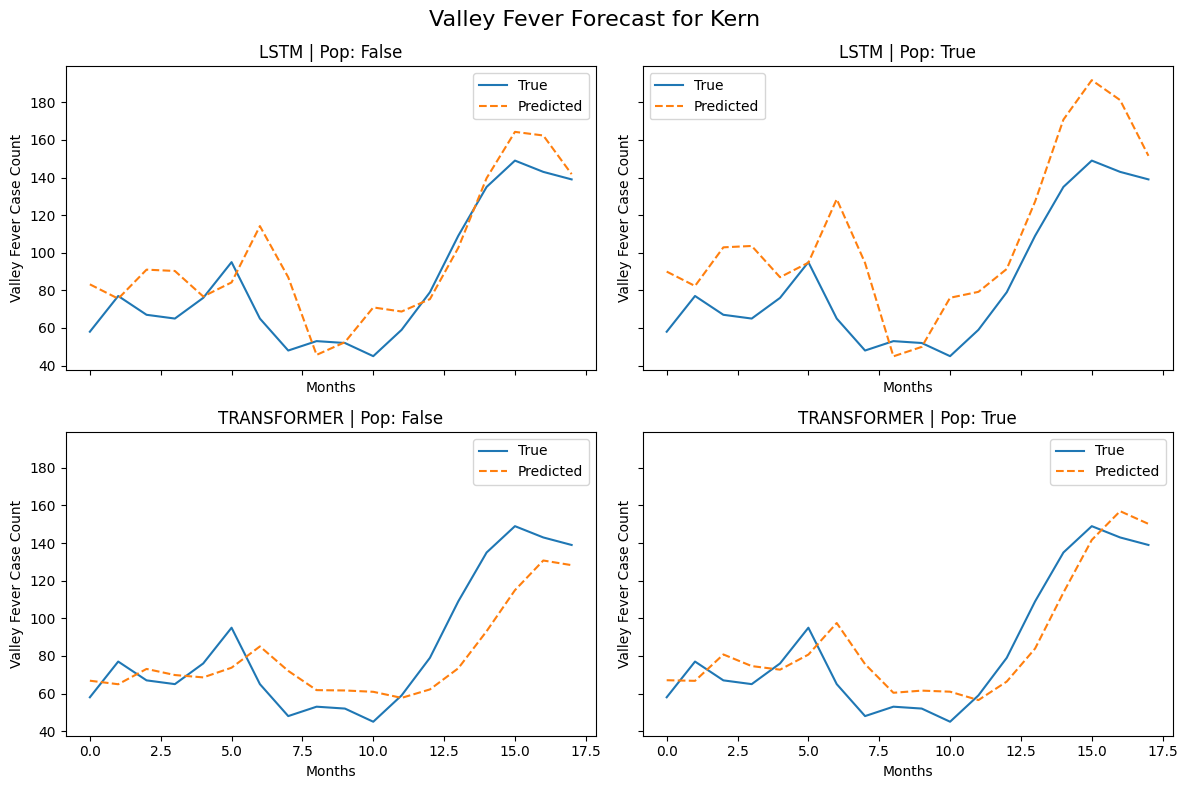

In [39]:
model_comparison_subplots_by_county("Kern")

## SandBox

Random area in case we want to play with code or model parameters

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2164, Testing Loss 0.4760
Epoch 11/300 - Training Loss 0.1188, Testing Loss 0.2726
Epoch 21/300 - Training Loss 0.1080, Testing Loss 0.3390
Epoch 31/300 - Training Loss 0.1073, Testing Loss 0.3190
Epoch 41/300 - Training Loss 0.1057, Testing Loss 0.3031
Epoch 51/300 - Training Loss 0.1049, Testing Loss 0.3074
Epoch 61/300 - Training Loss 0.1005, Testing Loss 0.2840
Epoch 71/300 - Training Loss 0.0956, Testing Loss 0.2574
Epoch 81/300 - Training Loss 0.0888, Testing Loss 0.2037
Epoch 91/300 - Training Loss 0.0893, Testing Loss 0.1771
Epoch 101/300 - Training Loss 0.0875, Testing Loss 0.1872
Epoch 111/300 - Training Loss 0.0872, Testing Loss 0.1912
Epoch 121/300 - Training Loss 0.0868, Testing Loss 0.1883
Epoch 131/300 - Training Loss 0.0874, Testing Loss 0.1853
Epoch 141/300 - Training Loss 0.0851, Testing Loss 0.1879
Epoch 151/300 - Training Loss 0.0832, Testing Loss 0.1859
Epoch 161/300 - Training Loss 0.0842, Testing Loss 0.1886
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.1960, Testing Loss 0.4576
Epoch 11/300 - Training Loss 0.1143, Testing Loss 0.2612
Epoch 21/300 - Training Loss 0.1021, Testing Loss 0.3170
Epoch 31/300 - Training Loss 0.0946, Testing Loss 0.2593
Epoch 41/300 - Training Loss 0.0872, Testing Loss 0.2388
Epoch 51/300 - Training Loss 0.0823, Testing Loss 0.1793
Epoch 61/300 - Training Loss 0.0826, Testing Loss 0.1714
Epoch 71/300 - Training Loss 0.0823, Testing Loss 0.1891
Epoch 81/300 - Training Loss 0.0823, Testing Loss 0.1939
Epoch 91/300 - Training Loss 0.0828, Testing Loss 0.1891
Epoch 101/300 - Training Loss 0.0817, Testing Loss 0.1895
Epoch 111/300 - Training Loss 0.0829, Testing Loss 0.1901
Epoch 121/300 - Training Loss 0.0833, Testing Loss 0.1923
Epoch 131/300 - Training Loss 0.0804, Testing Loss 0.1933
Epoch 141/300 - Training Loss 0.0802, Testing Loss 0.1943
Epoch 151/300 - Training Loss 0.0809, Testing Loss 0.1956
Epoch 161/300 - Training Loss 0.0814, Testing Loss 0.1955
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3717, Testing Loss 0.1918
Epoch 11/300 - Training Loss 0.2610, Testing Loss 0.3047
Epoch 21/300 - Training Loss 0.2178, Testing Loss 0.2911
Epoch 31/300 - Training Loss 0.1947, Testing Loss 0.2871
Epoch 41/300 - Training Loss 0.1320, Testing Loss 0.2839
Epoch 51/300 - Training Loss 0.1301, Testing Loss 0.2792
Epoch 61/300 - Training Loss 0.1229, Testing Loss 0.2747
Epoch 71/300 - Training Loss 0.1276, Testing Loss 0.2577
Epoch 81/300 - Training Loss 0.1124, Testing Loss 0.2454
Epoch 91/300 - Training Loss 0.1150, Testing Loss 0.2573
Epoch 101/300 - Training Loss 0.1089, Testing Loss 0.2435
Epoch 111/300 - Training Loss 0.1069, Testing Loss 0.2503
Epoch 121/300 - Training Loss 0.1021, Testing Loss 0.2538
Epoch 131/300 - Training Loss 0.1213, Testing Loss 0.2532
Epoch 141/300 - Training Loss 0.1044, Testing Loss 0.2468
Epoch 151/300 - Training Loss 0.1039, Testing Loss 0.2333
Epoch 161/300 - Training Loss 0.1118, Testing Loss 0.2297
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3645, Testing Loss 0.1605
Epoch 11/300 - Training Loss 0.2392, Testing Loss 0.1796
Epoch 21/300 - Training Loss 0.1642, Testing Loss 0.2265
Epoch 31/300 - Training Loss 0.1717, Testing Loss 0.2391
Epoch 41/300 - Training Loss 0.1420, Testing Loss 0.2294
Epoch 51/300 - Training Loss 0.1171, Testing Loss 0.2217
Epoch 61/300 - Training Loss 0.1063, Testing Loss 0.2158
Epoch 71/300 - Training Loss 0.1064, Testing Loss 0.2125
Epoch 81/300 - Training Loss 0.1133, Testing Loss 0.2146
Epoch 91/300 - Training Loss 0.1007, Testing Loss 0.2158
Epoch 101/300 - Training Loss 0.1013, Testing Loss 0.2152
Epoch 111/300 - Training Loss 0.0986, Testing Loss 0.2164
Epoch 121/300 - Training Loss 0.0984, Testing Loss 0.2046
Epoch 131/300 - Training Loss 0.1013, Testing Loss 0.2040
Epoch 141/300 - Training Loss 0.0964, Testing Loss 0.2058
Epoch 151/300 - Training Loss 0.0923, Testing Loss 0.1997
Epoch 161/300 - Training Loss 0.0903, Testing Loss 0.1940
Epoch 171/300 - Training 

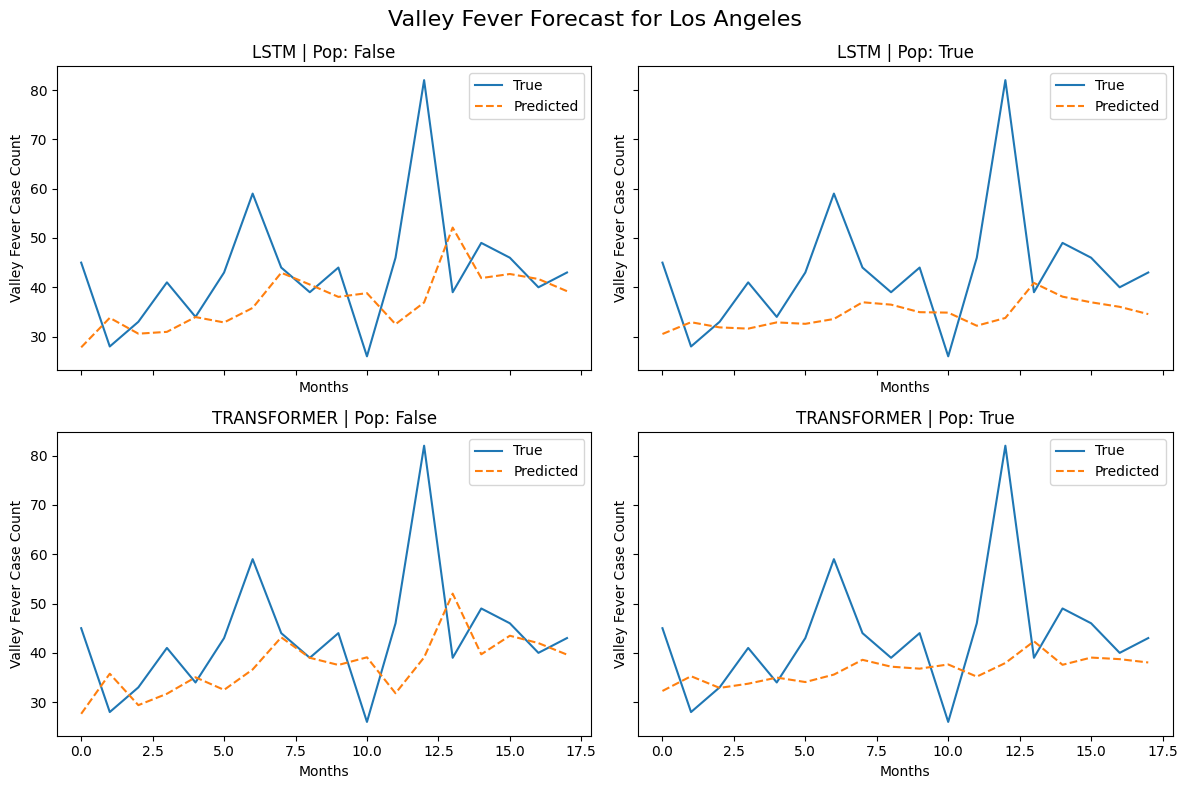

In [42]:
model_comparison_subplots_by_county("Los Angeles")

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3636, Testing Loss 0.4716
Epoch 11/300 - Training Loss 0.2401, Testing Loss 0.2693
Epoch 21/300 - Training Loss 0.2416, Testing Loss 0.2589
Epoch 31/300 - Training Loss 0.2391, Testing Loss 0.2888
Epoch 41/300 - Training Loss 0.2385, Testing Loss 0.2614
Epoch 51/300 - Training Loss 0.2380, Testing Loss 0.2628
Epoch 61/300 - Training Loss 0.2380, Testing Loss 0.2657
Epoch 71/300 - Training Loss 0.2372, Testing Loss 0.2564
Epoch 81/300 - Training Loss 0.2358, Testing Loss 0.2566
Epoch 91/300 - Training Loss 0.2353, Testing Loss 0.2484
Epoch 101/300 - Training Loss 0.2353, Testing Loss 0.2463
Epoch 111/300 - Training Loss 0.2317, Testing Loss 0.2390
Epoch 121/300 - Training Loss 0.2321, Testing Loss 0.2322
Epoch 131/300 - Training Loss 0.2293, Testing Loss 0.2237
Epoch 141/300 - Training Loss 0.2282, Testing Loss 0.2159
Epoch 151/300 - Training Loss 0.2299, Testing Loss 0.2097
Epoch 161/300 - Training Loss 0.2241, Testing Loss 0.2116
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4922, Testing Loss 0.6133
Epoch 11/300 - Training Loss 0.2947, Testing Loss 0.3534
Epoch 21/300 - Training Loss 0.2510, Testing Loss 0.2216
Epoch 31/300 - Training Loss 0.2422, Testing Loss 0.2884
Epoch 41/300 - Training Loss 0.2364, Testing Loss 0.2351
Epoch 51/300 - Training Loss 0.2375, Testing Loss 0.2535
Epoch 61/300 - Training Loss 0.2362, Testing Loss 0.2455
Epoch 71/300 - Training Loss 0.2377, Testing Loss 0.2412
Epoch 81/300 - Training Loss 0.2355, Testing Loss 0.2418
Epoch 91/300 - Training Loss 0.2344, Testing Loss 0.2365
Epoch 101/300 - Training Loss 0.2346, Testing Loss 0.2355
Epoch 111/300 - Training Loss 0.2335, Testing Loss 0.2319
Epoch 121/300 - Training Loss 0.2336, Testing Loss 0.2298
Epoch 131/300 - Training Loss 0.2330, Testing Loss 0.2267
Epoch 141/300 - Training Loss 0.2314, Testing Loss 0.2250
Epoch 151/300 - Training Loss 0.2319, Testing Loss 0.2222
Epoch 161/300 - Training Loss 0.2301, Testing Loss 0.2197
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 1.6267, Testing Loss 1.7275
Epoch 11/300 - Training Loss 0.4999, Testing Loss 0.3055
Epoch 21/300 - Training Loss 0.3557, Testing Loss 0.2235
Epoch 31/300 - Training Loss 0.3645, Testing Loss 0.3273
Epoch 41/300 - Training Loss 0.3330, Testing Loss 0.2201
Epoch 51/300 - Training Loss 0.2890, Testing Loss 0.2751
Epoch 61/300 - Training Loss 0.2791, Testing Loss 0.2348
Epoch 71/300 - Training Loss 0.2689, Testing Loss 0.2628
Epoch 81/300 - Training Loss 0.2627, Testing Loss 0.2426
Epoch 91/300 - Training Loss 0.2598, Testing Loss 0.2502
Epoch 101/300 - Training Loss 0.2735, Testing Loss 0.2420
Epoch 111/300 - Training Loss 0.2699, Testing Loss 0.2335
Epoch 121/300 - Training Loss 0.2475, Testing Loss 0.2467
Epoch 131/300 - Training Loss 0.2487, Testing Loss 0.2333
Epoch 141/300 - Training Loss 0.2489, Testing Loss 0.2446
Epoch 151/300 - Training Loss 0.2401, Testing Loss 0.2477
Epoch 161/300 - Training Loss 0.2408, Testing Loss 0.2411
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3720, Testing Loss 0.3126
Epoch 11/300 - Training Loss 0.2936, Testing Loss 0.2838
Epoch 21/300 - Training Loss 0.2803, Testing Loss 0.2522
Epoch 31/300 - Training Loss 0.2814, Testing Loss 0.2471
Epoch 41/300 - Training Loss 0.2448, Testing Loss 0.2412
Epoch 51/300 - Training Loss 0.2473, Testing Loss 0.2564
Epoch 61/300 - Training Loss 0.2468, Testing Loss 0.2538
Epoch 71/300 - Training Loss 0.2511, Testing Loss 0.2401
Epoch 81/300 - Training Loss 0.2304, Testing Loss 0.2309
Epoch 91/300 - Training Loss 0.2415, Testing Loss 0.2418
Epoch 101/300 - Training Loss 0.2373, Testing Loss 0.2492
Epoch 111/300 - Training Loss 0.2384, Testing Loss 0.2525
Epoch 121/300 - Training Loss 0.2395, Testing Loss 0.2448
Epoch 131/300 - Training Loss 0.2350, Testing Loss 0.2343
Epoch 141/300 - Training Loss 0.2343, Testing Loss 0.2306
Epoch 151/300 - Training Loss 0.2428, Testing Loss 0.2453
Epoch 161/300 - Training Loss 0.2423, Testing Loss 0.2346
Epoch 171/300 - Training 

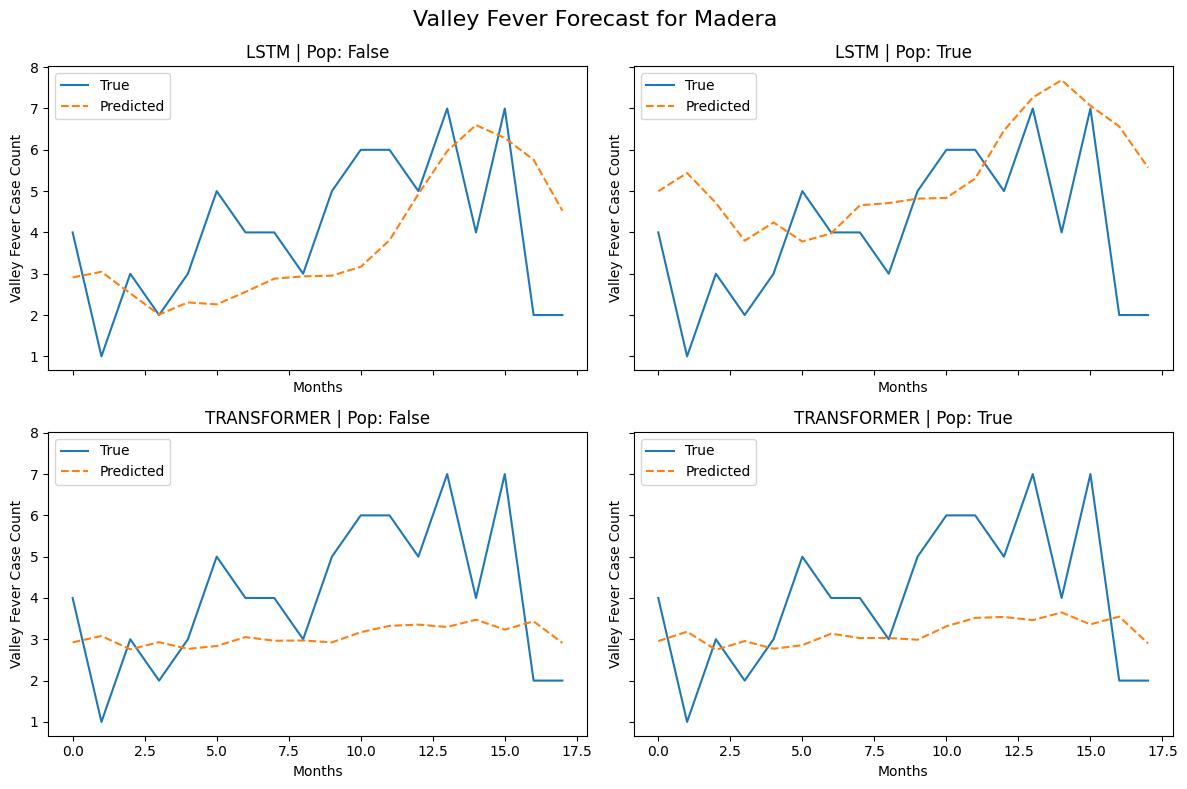

In [43]:
model_comparison_subplots_by_county("Madera")

## Potential Path Forward

1. When linearly interpolating the population count on a monthly basis, consider looking into the case rates (count / pop_per_100k) and see how that changes vs the copy yearly onto monthly case rates.

2. Look into case_rates instead of case_count

3. Create a table of the incident types and counts for each of them, by county (especially good for attention visualization)
    - look into potential acres burned as well to see if there is a tie to that value

4. Potential Project Stopping Point:
    - Transformer vs LSTM benchmark/comparison with all environmental data (harness created)
    - Include more granularity (like adding linear interpolation for population count) [next on list]
        - Include the change to case rates and see how this works
    - Visualize attention and look into other explainability metrics for the Transformer model
    - Add more environmental factors like pesticide and make a dashboard that includes these items 
        - layout idea: map of counties on the left, highlight the county or add interactivity so someone can click it
            - give the user a choice of model, type of factors they want to use, then show the results
            - use the attention visualization as well